# 1. Single individual experiment
This experiment trains the models on 1 mouse and on the first day of data, and tests the models the same mouse but for days 2, 3 and 4.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import lib.features as features
import lib.breeds as breeds
import lib.plots as plots
import lib.models as models

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data_folder = '../data/csv/'
data_files = [mice + ".smo.csv" for mice in breeds.mice_breeds["c57bl6"]][:1] # select one mouse
print(f'Using mice: {data_files}')

days_train = [0]
days_test = [1, 2, 3]
window_sizes = [2, 5, 10, 20, 50, 100]
window_features = ["EEGv", "EMGv"]
spectral=True
rolloffs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
useRaw = False
dropBins = True
cat_matrix = True # True for neural net, any for random forest
standardize_df = False
test_size = 0.3

lr=1e-4
epochs=150
batch_size=64

seed = 13

Using mice: ['BL601.smo.csv']


In [3]:
# train and test on same mice
df_train = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files,
    days=days_train, 
    window_sizes=window_sizes, 
    window_features=window_features,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=True, 
    standardize_df=standardize_df,
    seed=seed,
)

df_test = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files,
    days=days_test, 
    window_sizes=window_sizes, 
    window_features=window_features,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=False, 
    standardize_df=standardize_df,
    seed=seed,
)

x_train, x_test, y_train, y_test, le = features.encode_scale_data(df_train, df_test, useRaw, seed, cat_matrix)

# Neural Network

In [4]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=lr)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 246       
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

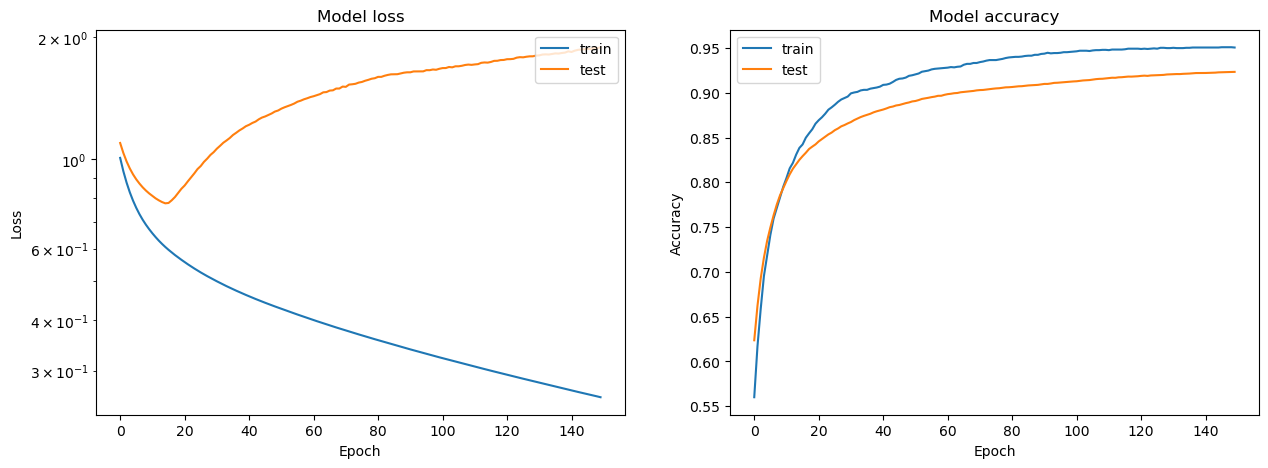

In [11]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=lr)

history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_history(history.history)

# Exporting/loading model

In [12]:
# Save model if needed
# model.save('models/experiment1-neuralnet.h5')

1982/1982 [==============================] - 1s 644us/step
[[25315  1590   894]
 [   62  2824    10]
 [  889  1420 30407]]
              precision    recall  f1-score   support

           n       0.96      0.91      0.94     27799
           r       0.48      0.98      0.65      2896
           w       0.97      0.93      0.95     32716

    accuracy                           0.92     63411
   macro avg       0.81      0.94      0.84     63411
weighted avg       0.95      0.92      0.93     63411



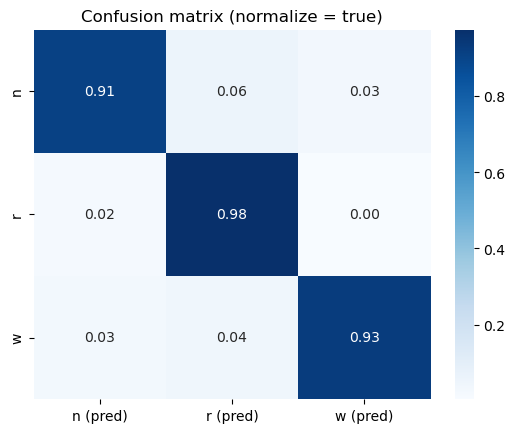

In [13]:
# Load model if needed
# model = tf.keras.models.load_model('models/experiment1-neuralnet.h5')
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# Random Forest

[[26547   971   281]
 [  123  2764     9]
 [ 2152  1049 29515]]
              precision    recall  f1-score   support

           n       0.92      0.95      0.94     27799
           r       0.58      0.95      0.72      2896
           w       0.99      0.90      0.94     32716

    accuracy                           0.93     63411
   macro avg       0.83      0.94      0.87     63411
weighted avg       0.94      0.93      0.93     63411



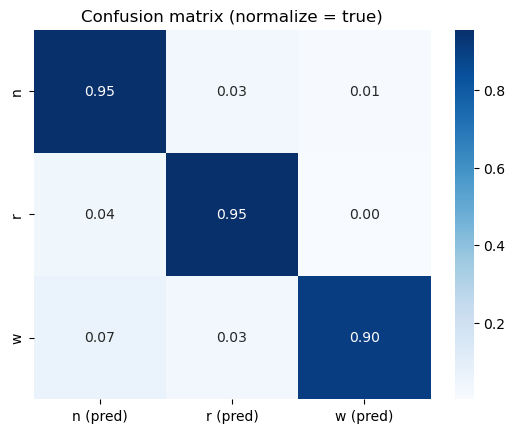

In [7]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)
plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')